# SPO2IDA

The aim of this procedure is the estimation of the median spectral acceleration value that brings the structure to the attainment of a set of damage states ds, and the corresponding dispersion. The aim is achieved making use of the tool spo2ida (Vamvatsikos and Cornell, 2006), where static pushover curves are converted into 16%, 50% and 84% ida curves, using empirical relationships from a large database of incremental dynamic analysis results, as shown in the figure below.

<img src="../../../../../figures/spo2ida.jpg" height="200" width="500" align="middle">

##Load pushover curves

In order to use this methodology, it is necessary to provide one (or a group) of pushover curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). The user needs to provide the following information:
- The location of the folder containing the pushover curves using the parameter capacity_curves_file.
- The type of information provided in the input using the parameter input_type. The user can provide either base shear and top displacement or base shear and displacement of each storey.
- A spectral shape in case multiple pushover curves are input.

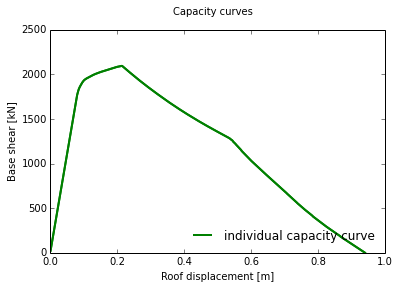

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_Vb-dfloor.csv'
input_type = 'Vb-dfloor'
input_spectrum = '../../../../../../rmtk_data/FEMAP965spectrum.txt'

capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
Sa_ratios = utils.get_spectral_ratios(capacity_curves,input_spectrum)


##Idealise pushover curves

In order to use this methodology the pushover curves needs to be idealised. Please choose an idealised shape (either bilinear or quadrilinear) using the parameter idealised_type. Idealised curves can be directly provided as input setting the field 'Idealised' to TRUE in the input_file.

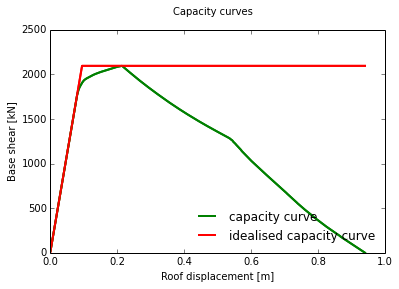

In [2]:
idealised_type = 'bilinear'

idealised_capacity = utils.idealisation(idealised_type, capacity_curves)
utils.plot_idealised_capacity(idealised_capacity, capacity_curves, idealised_type)

##Load damage state thresholds

Please define in the variable damage_state_file the path to your damage model.

In [3]:
damage_model_file = '../../../../../../rmtk_data/damage_model_ISD.csv'
damage_model = utils.read_damage_model(damage_model_file)
print damage_model

{'dispersion': [[0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05]], 'type_criteria': 'interstorey drift', 'distribution': ['normal', 'normal', 'normal', 'normal'], 'median': [[0.005, 0.01, 0.02, 0.05], [0.005, 0.01, 0.02, 0.05]], 'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse']}


##Calculate fragility functions

The damage threshold dispersion is calculated and integrated with the record-to-record dispersion making use of monte carlo simulations. Please enter the number of monte carlo simulations that want to be performed in the variables montecarlo_samples.
Decide to display ida curves derived with spo2ia tool, setting the variables ida_plotflag to 1 (display) or 0 (do not display).

ac<0.02, it must be in [0.02,4], changed to ac = 0.02
mc = 9.88196138931 We must have "mc" in [1,9]


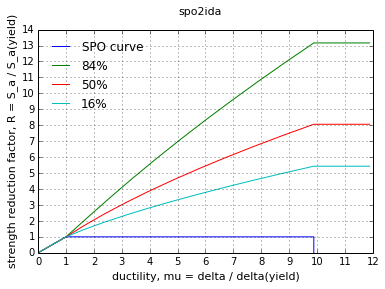

mu(LS) =  [ 1.11891707  2.22455475  4.97306038  9.21630637]
median IM =  [ 0.12783069  0.26057344  0.53259024  0.87153369]
total dispersion =  [ 0.06795204  0.23615676  0.36304139  0.42673338]


In [4]:
montecarlo_samples = 25
ida_plotflag = 1

from rmtk.vulnerability.derivation_fragility.R_mu_T_dispersion.SPO2IDA import SPO2IDA_procedure 

fragility_model = SPO2IDA_procedure.calculate_fragility(capacity_curves, idealised_capacity, damage_model, montecarlo_samples, Sa_ratios, ida_plotflag)

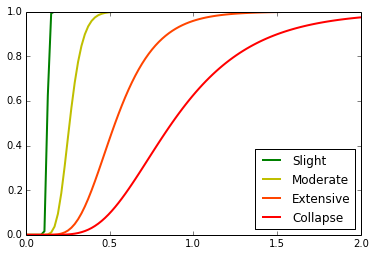

In [5]:
output_type = 'mean-sigma'
#'median-dispersion' #'logmean-cov' #'mean-sigma'
save = 1

utils.plot_fragility_model(fragility_model,0.01,2,save)
utils.create_fragility_out_files(fragility_model,output_type,save)